In [129]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import requests
    import json
except ImportError:
    %pip install pandas numpy matplotlib requests
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import requests
    import json

# ==========================================
# 1. THE "PLANT" (Simulation Environment)
# ==========================================

In [130]:
class SmartHomeEnv:
    def __init__(self, battery_capacity=10.0, max_power=5.0, seed=42):
        self.battery_capacity = battery_capacity # kWh
        self.max_power = max_power # kW
        self.soc = 0.0 # Initial State of Charge (kWh)
        self.time_step = 0

        # Set a fixed seed for reproducibility
        np.random.seed(seed)

        # Internal Data Generation (The "Real World")
        self.data = self._generate_scenario_data(hours=72)

    def _generate_scenario_data(self, hours):
        t = np.arange(hours)
        # Solar: Peak at noon + random clouds
        solar = np.maximum(0, 5 * np.sin(2 * np.pi * (t - 6) / 24))
        solar = np.maximum(0, solar - 0.3 * np.random.weibull(0.5, size=hours))

        # Load: Morning/Evening peaks
        load = 2 + np.cos(4 * np.pi * (t - 18) / 24) + \
                0.8 * np.cos(2 * np.pi * (t - 14) / 24)
        load = np.maximum(0.5, load)
        # Price: High in evening
        price = 0.20 + 0.20 * np.cos(2 * np.pi * (t - 18) / 24)

        return pd.DataFrame({'solar': solar, 'load': load, 'price': price})

    def reset(self):
        self.soc = 0.0
        self.time_step = 0
        return self.data.iloc[0]

    def step(self, action_kw):
        """
        Executes one time step.
        Args:
            action_kw (float): Desired battery power (+ Charge, - Discharge)
        Returns:
            observation (Series): The NEXT state (load, solar, price)
            reward (float): The cost incurred this step
            done (bool): Is simulation over?
            info (dict): Debug info
        """
        current_data = self.data.iloc[self.time_step]

        # --- 1. Apply Physics Constraints (The "Real" Battery) ---
        # A. Power Limits
        power = np.clip(action_kw, -self.max_power, self.max_power)

        # B. Capacity Limits
        if power > 0: # Charging
            max_charge = self.battery_capacity - self.soc
            power = min(power, max_charge)
        else: # Discharging
            max_discharge = self.soc
            power = max(power, -max_discharge) # (power is negative)

        # --- 2. Update State ---
        self.soc += power # Simple energy bucket model (1 hour timestep)

        # --- 3. Calculate Cost ---
        # Grid Balance: Load + Charge = Solar + Discharge + Grid
        # Grid = (Load - Solar) + Power
        net_load = current_data['load'] - current_data['solar']
        grid_kw = net_load + power

        cost = grid_kw * current_data['price']

        # --- 4. Prepare Next Step ---
        self.time_step += 1
        done = self.time_step >= len(self.data)

        next_obs = None
        if not done:
            next_obs = self.data.iloc[self.time_step]

        info = {
            'soc': self.soc,
            'grid_kw': grid_kw,
            'battery_action_actual': power,
            'load': current_data['load'],
            'solar': current_data['solar'],
            'price': current_data['price']
        }

        return next_obs, cost, done, info

    def get_forecast(self, horizon=24):
        """Returns the data for the next N hours (for MPC)"""
        start = self.time_step
        end = min(start + horizon, len(self.data))
        return self.data.iloc[start:end]

In [131]:
# --- Define the Gymnasium Environment Wrapper ---
try:
    from pathlib import Path
    import gymnasium as gym
    from gymnasium import spaces
    from stable_baselines3 import PPO
    from stable_baselines3.common.env_checker import check_env
except ImportError:
    %pip install stable-baselines3 gymnasium shimmy
    from pathlib import Path
    import gymnasium as gym
    from gymnasium import spaces
    from stable_baselines3 import PPO
    from stable_baselines3.common.env_checker import check_env

class HEMSGymEnv(gym.Env):
    """
    Gymnasium wrapper for SmartHomeEnv to make it compatible with Stable Baselines3.
    """
    def __init__(self):
        super(HEMSGymEnv, self).__init__()
        self.env = SmartHomeEnv()
        
        # Action space: Continuous [-1, 1] representing fraction of max power
        # We will scale this to [-max_power, max_power] inside step()
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Observation space: [solar, load, price, soc]
        # We use -inf to inf to avoid bounds issues, but in practice these are bounded
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Reset internal env
        obs_series = self.env.reset()
        
        # Construct observation
        self.current_obs = np.array([
            obs_series['solar'],
            obs_series['load'],
            obs_series['price'],
            self.env.soc
        ], dtype=np.float32)
        
        return self.current_obs, {}

    def step(self, action):
        # Scale action [-1, 1] -> [-max_power, max_power]
        action_kw = float(action[0]) * self.env.max_power
        
        # Step internal env
        next_obs_series, cost, done, info = self.env.step(action_kw)
        
        # Reward: Negative cost (Maximize negative cost => Minimize cost)
        reward = -cost
        
        # Update observation
        if not done:
            self.current_obs = np.array([
                next_obs_series['solar'],
                next_obs_series['load'],
                next_obs_series['price'],
                self.env.soc
            ], dtype=np.float32)
        else:
            # If done, next_obs might be None or we just return the last one
            pass

        terminated = done
        truncated = False
        
        return self.current_obs, reward, terminated, truncated, info


In [132]:
class HEMSSelfsufficientGymEnv(HEMSGymEnv):
    def step(self, action):
        self.current_obs, reward, terminated, truncated, info = super().step(action)


        if info['solar'] > 0:
            reward = (min(info['solar'], info['load'] + info['battery_action_actual']))/ info['solar']* 10
        else:
            reward = 0.0
        reward = -abs(info['grid_kw'])
        return self.current_obs, reward, terminated, truncated, info


# --- Train the Agents ---
envs = {
    "ppo_hems_cost_model.zip": HEMSGymEnv,
    "ppo_hems_selfsufficient_model.zip": HEMSSelfsufficientGymEnv,
    }

In [133]:
for rl_model_path, GymEnv in envs.items():
    rl_model_path = Path(rl_model_path)
    if rl_model_path.exists():
        print(f"Trained Model exists at {rl_model_path}")
    else:
        print(f"Training RL Agent {rl_model_path}... this might take a minute.")
        train_env = GymEnv()
        # Use MlpPolicy (Multi-Layer Perceptron) suitable for vector observations
        rl_model = PPO("MlpPolicy", train_env, verbose=0, learning_rate=0.0003, n_steps=2048)
        rl_model.learn(total_timesteps=50000)
        rl_model.save(rl_model_path)
        print("Training Complete. Model saved.")

Trained Model exists at ppo_hems_cost_model.zip
Trained Model exists at ppo_hems_selfsufficient_model.zip


# ==========================================
# 2. THE CONTROLLERS
# ==========================================

In [134]:
class Controller:
    """Base controller: stores battery capacity and max power values and defines interface."""
    def __init__(self, env):
        self.bat_cap = env.battery_capacity
        self.max_p = env.max_power

    def get_action(self, observation, current_soc):
        raise NotImplementedError

In [135]:
class BasicController(Controller):
    """Store all solar; discharge battery completely."""

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        if net_load < 0:
            return self.max_p
        else:
            return -self.max_p

In [136]:
class ResidualChargeController(Controller):
    """Store excess solar; discharge to meet deficits."""

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        if net_load < 0:
            return min(self.max_p, -net_load)
        else:
            return -min(self.max_p, net_load)

In [137]:
class CostOptimizedBasicController(Controller):
    """Charge from solar; discharge when price is high; otherwise hold."""
    def __init__(self, env, price_threshold=0.20):
        super().__init__(env)
        self.price_threshold = price_threshold

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        current_price = observation['price']
        if net_load < 0:
            return self.max_p
        else:
            if current_price > self.price_threshold:
                return -self.max_p
            else:
                return 0.0

In [138]:
class CostOptimizedResidualController(Controller):
    """Charge from surplus solar; discharge to cover residual load when price is high; otherwise hold."""
    def __init__(self, env, price_threshold=0.20):
        super().__init__(env)
        self.price_threshold = price_threshold

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        current_price = observation['price']
        if net_load < 0:
            return min(self.max_p, -net_load)
        else:
            if current_price > self.price_threshold:
                return -min(self.max_p, net_load)
            else:
                return 0.0

In [ ]:
class UrbsMPCController(Controller):
    """MPC controller using Urbs for optimization with perfect foresight."""
    def __init__(self, env, url="http://localhost:5000/simulate"):
        super().__init__(env)
        self.url = url
        self.plan = None
        self.env = env # Need access to env for full forecast
        self.horizon = 10000

    def get_action(self, observation, current_soc):
        # Plan once at the beginning (Perfect Foresight)
        if self.plan is None:
            self.plan = self._run_optimization(horizon=self.horizon)
        
        # Get action for current timestep
        t = self.env.time_step
        if t < len(self.plan):
            return self.plan[t]
        else:
            return 0.0

    def _run_optimization(self,horizon=10000):
        # 1. Get Full Forecast
        # We need the full data. env.data is available since we passed env.
        # But to be clean, let's use get_forecast with a large horizon.
        full_data = self.env.get_forecast(horizon=horizon) # Get everything
        timesteps = len(full_data)
        
        # 2. Construct JSON Payload
        # Normalize Solar: Urbs SupIm is usually a profile. 
        # We'll set installed capacity to max(solar) and profile to solar/max.
        solar_profile = full_data['solar'].values
        max_solar = solar_profile.max()
        if max_solar == 0: max_solar = 1.0
        norm_solar = (solar_profile / max_solar).tolist()
        
        load_profile = full_data['load'].tolist()
        price_profile = full_data['price'].tolist()
        
        payload = {
            "c_timesteps": timesteps,
            "global": {
                "CO2 limit": 1e15, # Infinite
                "Cost limit": 1e15 # Infinite
            },
            "site": {
                "Main": {
                    "area": 100,
                    "commodity": {
                        "Elec": {
                            "Type": "Demand",
                            "demand": load_profile
                        },
                        "SolarRes": {
                            "Type": "SupIm",
                            "supim": norm_solar
                        },
                        "Grid": {
                            "Type": "Buy",
                            "price": price_profile
                        }
                    },
                    "process": {
                        "PV": {
                            "inst-cap": max_solar,
                            "cap-lo": max_solar,
                            "cap-up": max_solar,
                            "commodity": {
                                "SolarRes": { "Direction": "In", "ratio": 1 },
                                "Elec": { "Direction": "Out", "ratio": 1 }
                            }
                        },
                        "GridImport": {
                            "inst-cap": 0,
                            "cap-lo": 0,
                            "cap-up": -1,
                            "commodity": {
                                "Grid": { "Direction": "In", "ratio": 1 },
                                "Elec": { "Direction": "Out", "ratio": 1 }
                            }
                        }
                    },
                    "storage": {
                        "Battery": {
                            "inst-cap-c": self.bat_cap,
                            "cap-lo-c": self.bat_cap,
                            "cap-up-c": self.bat_cap,
                            "inst-cap-p": self.max_p,
                            "cap-lo-p": self.max_p,
                            "cap-up-p": self.max_p,
                            "eff-in": 1.0,
                            "eff-out": 1.0,
                            "commodity": "Elec",
                            "init": 0.0
                        }
                    }
                }
            }
        }
        
        # 3. Send Request
        try:
            response = requests.post(self.url, json=payload)
            response.raise_for_status()
            result = response.json()
            
            # 4. Parse Result
            # result['results']['Main']['Elec']['storage']['Stored'] (Charge)
            # result['results']['Main']['Elec']['storage']['Retrieved'] (Discharge)
            storage_res = result['results']['Main']['Elec']['storage']
            charge = np.array(storage_res['Stored'])
            discharge = np.array(storage_res['Retrieved'])
            
            # Net action: Charge - Discharge
            # Note: SmartHomeEnv expects positive for Charge, negative for Discharge.
            actions = charge - discharge
            return actions
            
        except Exception as e:
            print(f"Optimization failed: {e}")
            # Fallback: Do nothing
            return np.zeros(timesteps)

In [140]:
class LimitedURBSController(UrbsMPCController):
    """MPC controller using Urbs for optimization with perfect foresight and limited horizon."""
    def __init__(self, env, url="http://localhost:5000/simulate"):
        super().__init__(env, url)
        self.horizon = 24

    def get_action(self, observation, current_soc):
        # Plan once at the beginning (Perfect Foresight)
        if self.plan is None:
            self.plan = self._run_optimization(horizon=self.horizon)
        
        # Get action for current timestep
        t = self.env.time_step
        if t < len(self.plan):
            return self.plan[t]
        else:
            return 0.0

In [141]:
class SB3RLCostController(Controller):
    """
    Controller that uses the pre-trained Stable Baselines3 model with cost optimization.
    """
    def __init__(self, env):
        super().__init__(env)
        self.model = PPO.load("ppo_hems_cost_model.zip")

    def get_action(self, observation, current_soc):
        # Prepare observation for the model
        obs_vector = np.array([
            observation['solar'],
            observation['load'],
            observation['price'],
            current_soc
        ], dtype=np.float32)
        
        # Predict (deterministic=True for evaluation)
        action, _ = self.model.predict(obs_vector, deterministic=True)
        
        # Scale back to kW
        return action[0] * self.max_p

In [142]:
class SB3RLSelfSufficientController(SB3RLCostController):
    """
    Controller that uses the pre-trained Stable Baselines3 model with self sufficiency optimization.
    """
    def __init__(self, env):
        super(SB3RLCostController, self).__init__(env)
        self.model = PPO.load("ppo_hems_selfsufficient_model.zip")


# ==========================================
# 3. MAIN LOOP (The "Gym" Loop)
# ==========================================

In [143]:
def run_experiment(Controller):
    # Setup
    env = SmartHomeEnv()
    agent = Controller(env)
   # agent = CostOptimizedRuleBasedController(env)
   # agent = SOCAwareRuleBasedController(env)
    # History Storage
    results = []

    # Start
    obs = env.reset()
    done = False

    print("Starting Simulation...")

    while not done:
        # 1. Agent decides
        # Note: RuleBased needs current SOC to be perfect, but here we
        # just ask for MAX and let physics clip it.
        action_requested = agent.get_action(obs, env.soc)

        # 2. Environment reacts
        next_obs, cost, done, info = env.step(action_requested)



        # 3. Store Data
        info['action_requested'] = action_requested # Log the requested action
        info['cost'] = cost
        results.append(info)


        # 4. Advance
        obs = next_obs

    # Process Results
    df_res = pd.DataFrame(results)
    return df_res

# ==========================================
# 4. VISUALIZATION
# ==========================================

In [144]:
def plot_controller_performance(df, controller_name, total_cost):
    print(f"Total Cost for {controller_name}: €{total_cost:.2f}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Ax1: Physics
    ax1.set_title(f"{controller_name}: Power Flows")
    ax1.plot(df['load'], 'k--', label='Load', alpha=0.5)
    ax1.plot(df['solar'], 'orange', label='Solar', alpha=0.5)
    ax1.bar(df.index, df['battery_action_actual'], color='green', alpha=0.3, label='Battery Flow')
    ax1.legend()
    ax1.set_ylabel("kW")

    # Ax2: Battery State
    ax2.set_title(f"{controller_name}: Battery State of Charge")
    ax2.plot(df['soc'], 'g-', linewidth=2)
    ax2.set_ylabel("kWh")
    ax2.set_xlabel("Hour")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# 5. COMPARISON
# ==========================================

Starting Simulation...
Starting Simulation...
Starting Simulation...
Starting Simulation...
Starting Simulation...
Optimization failed: 'results'
Starting Simulation...
Optimization failed: 'results'


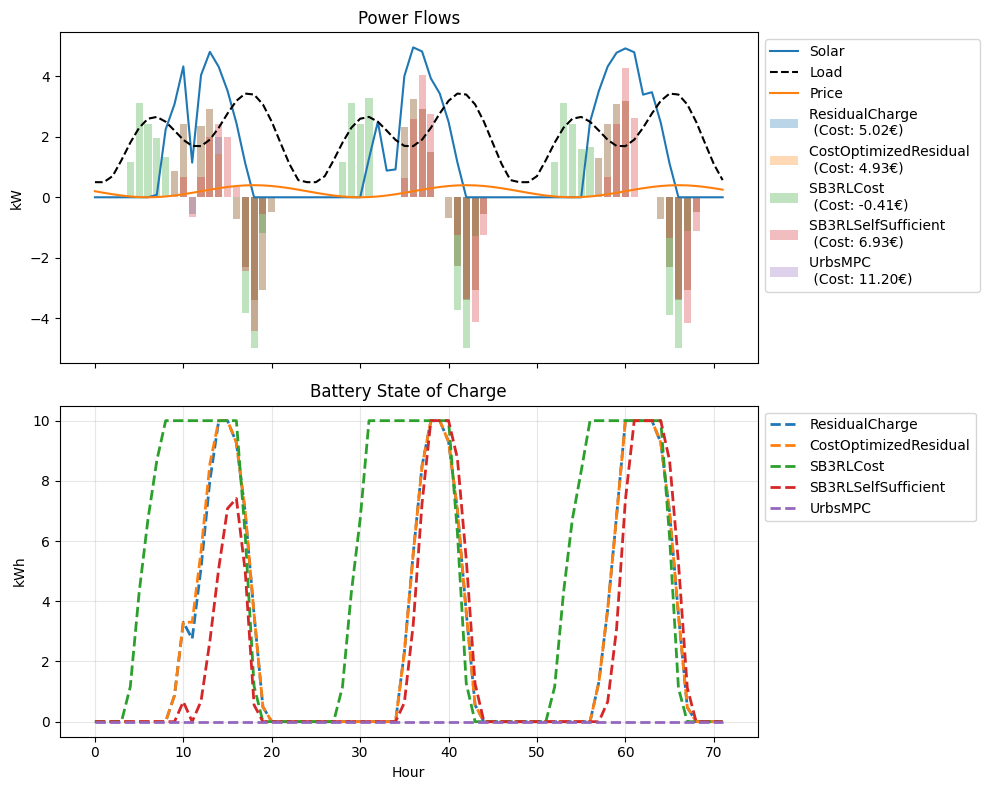

In [145]:
controllers = {
    # "Basic": BasicController,
    "ResidualCharge": ResidualChargeController,
    # "CostOptimizedBasic": CostOptimizedBasicController,
    "CostOptimizedResidual": CostOptimizedResidualController,
    # "LimitedURBS": LimitedURBSController,
    "SB3RLCost": SB3RLCostController,
    "SB3RLSelfSufficient": SB3RLSelfSufficientController,
    "UrbsMPC": UrbsMPCController
}

all_results = {}
for name, controller in controllers.items():
    all_results[name] = run_experiment(controller)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
df = list(all_results.values())[0]
ax1.plot(df['solar'], label='Solar')
ax1.plot(df['load'], 'k--', label='Load')
ax1.plot(df['price'], label='Price')
for name, df in all_results.items():
    total_cost = df['cost'].sum()
    # print(f"Total Cost for {name}: €{total_cost:.2f}")


    # Ax1: Physics
    ax1.set_title("Power Flows")


    ax1.bar(df.index, df['battery_action_actual'], alpha=0.3, label=f'{name} \n (Cost: {total_cost:.2f}€)')
    ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax1.set_ylabel("kW")

    # Ax2: Battery State
    ax2.set_title("Battery State of Charge")
    ax2.plot(df['soc'], '--', linewidth=2, label=f"{name}")
    ax2.set_ylabel("kWh")
    ax2.set_xlabel("Hour")
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')

    plt.tight_layout()
plt.show()